# Training on Text-only BERT Embeddings

In [1]:
# !pip install tensorflow-text
# !pip install bert-tensorflow
# !pip install tf-models-official

In [3]:
import os, tensorflow as tf, tensorflow_hub as hub, tensorflow_text as text, numpy as np, pandas as pd
from sklearn.metrics import classification_report, roc_curve, det_curve, precision_recall_curve, roc_auc_score, accuracy_score,confusion_matrix

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from classificationreport import ClassificationReport ## this is a python script provided in the directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, we import the train and test CSVs, which consists of the 'Utterences' for each audio segment.

In [4]:
train_df=pd.read_csv("/content/drive/MyDrive/DL_Emotion_Classification/train_sent_emo.csv",encoding='latin1')

In [5]:
train_df.shape

(9988, 11)

In [7]:
test_df=pd.read_csv("/content/drive/MyDrive/DL_Emotion_Classification/test_sent_emo.csv",encoding='latin1')

In [8]:
test_df.shape

(2610, 11)

The emotions are labeled by any of these seven emotions -- Anger, Disgust, Sadness, Joy, Neutral, Surprise and Fear. Machine learning models typically work with numerical data, so we need to do Label encoding which converts categorical labels into numeric values, allowing the model to process and learn from them.

In [9]:
le = LabelEncoder()

train_df['emotion_encoded'] = le.fit_transform(train_df['Emotion'])
test_df['emotion_encoded'] = le.transform(test_df['Emotion'])
class_names_encoded = le.classes_

y_train = train_df['Emotion']
y_train_encoded = train_df['emotion_encoded']

y_test = test_df['Emotion']
y_test_encoded = test_df['emotion_encoded']

In [10]:
y_train_encoded = to_categorical(np.array(y_train_encoded))
y_test_encoded = to_categorical(np.array(y_test_encoded))

In [11]:
x_train = train_df['Utterance']
x_test = test_df['Utterance']

Since the zip file of the validation set provided with the MELD dataset was corrupted, we created our own validation split from the train data.

In [12]:
X_train, X_val, Y_train_encoded, Y_val_encoded = train_test_split(x_train, y_train_encoded, test_size=0.2, random_state=42)

We load the BERT text preprocessing model from TensorFlow Hub. The BERT model for English text, with uncased vocabulary, and version 3 is used. The `hub.KerasLayer` allows the model to be used as a Keras layer within the TensorFlow framework. The purpose of this preprocessing model is to tokenize and preprocess the input text to be compatible with BERT's input requirements. 
<br>
Then we load the BERT encoder model from TensorFlow Hub. The BERT base model for English text, with an uncased vocabulary, 12 layers, 768 hidden units, and 12 attention heads is used. This model is responsible for encoding the preprocessed text into meaningful representations or embeddings. 

In [13]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [14]:
type = 'BERT_LSTM'

We use checkpoints and early stopping to ensure that the model stops training before it starts to overfit on the training data.

In [15]:
checkpoint = ModelCheckpoint(type + '.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience=10, mode = "max", restore_best_weights = True, verbose=1)

In [16]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
LSTM_Layer = tf.keras.layers.LSTM(units=128)(outputs['sequence_output'])
Dropout_Layer = tf.keras.layers.Dropout(0.1, name="dropout")(LSTM_Layer)
Dense_Layer = tf.keras.layers.Dense(7, activation='softmax', name="output")(Dropout_Layer)
model = tf.keras.Model(inputs=[text_input], outputs = [Dense_Layer])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [17]:
model.fit(X_train, Y_train_encoded, epochs=50, batch_size = 32,callbacks=[es, checkpoint], verbose=1, validation_data=(X_val, Y_val_encoded), shuffle=True)

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 1.2204 - accuracy: 0.5910
Epoch 1: val_accuracy improved from -inf to 0.60511, saving model to BERT_LSTM.h5
250/250 [==============================] - 147s 524ms/step - loss: 1.2204 - accuracy: 0.5910 - val_loss: 1.1894 - val_accuracy: 0.6051
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 1.1159 - accuracy: 0.6269
Epoch 2: val_accuracy improved from 0.60511 to 0.61211, saving model to BERT_LSTM.h5
250/250 [==============================] - 110s 441ms/step - loss: 1.1159 - accuracy: 0.6269 - val_loss: 1.1437 - val_accuracy: 0.6121
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 1.0707 - accuracy: 0.6384
Epoch 3: val_accuracy did not improve from 0.61211
250/250 [==============================] - 128s 513ms/step - loss: 1.0707 - accuracy: 0.6384 - val_loss: 1.1386 - val_accuracy: 0.6096
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 1.0301 - accuracy: 

The Loss and Accuracy of the trained model on the test set is given below - 

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test_encoded)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

82/82 [==============================] - 29s 347ms/step - loss: 1.0978 - accuracy: 0.6337
Test loss: 1.0978416204452515
Test accuracy: 0.6337164640426636


As we can see, the Text-only model using BERT performs significantly better than the Audio model using Mel-bin Spectrograms or MFCCs.

In [19]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

82/82 [==============================] - 29s 336ms/step


In [21]:
y_test_encoded = np.argmax(y_test_encoded, axis=1)

In [22]:
print(classification_report(y_test_encoded, y_pred, target_names=class_names_encoded))

              precision    recall  f1-score   support

       anger       0.51      0.37      0.43       345
     disgust       0.25      0.04      0.07        68
        fear       0.00      0.00      0.00        50
         joy       0.56      0.57      0.57       402
     neutral       0.70      0.89      0.78      1256
     sadness       0.42      0.15      0.23       208
    surprise       0.55      0.49      0.52       281

    accuracy                           0.63      2610
   macro avg       0.43      0.36      0.37      2610
weighted avg       0.59      0.63      0.60      2610



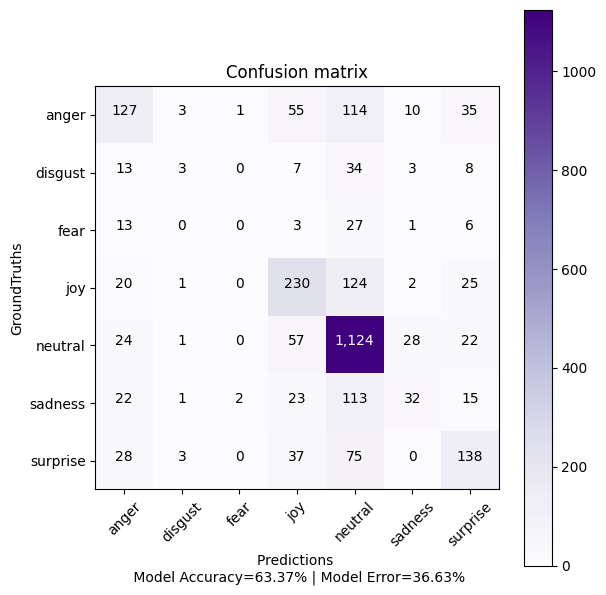

In [23]:
cm = confusion_matrix(y_test_encoded, y_pred)
cr = ClassificationReport()
cr.plot_confusion_matrix(cm=cm, normalize = False, target_names = class_names_encoded)